In [2]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import skimage
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation, erosion, opening
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [3]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [4]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    # image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    # image = exposure.equalize_adapthist(image)
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
        # Method 1: Adaptive Histogram Equalization (CLAHE)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


## Histogram Matching

In [5]:

def hist_match(img, hist, L): # histogram matchin of image to target average histogram
    '''
    matches the histogram of the current image to a precomputed target histogram
    the target is the average cdf of all images in the training set.
    this is the code that bria wrote in class, translated by chatgpt and then modified by me to take
    a histogram instead of an image (and all other implementations of this also just take an image like wtf that is so useless unless you have a perfect image???????? WHY)
    anyway, sometimes gives a warning when information is lost because float 32 doesnt provide enough decimals but we ignore that, cause its just minute information that shouldnt change much
    '''
    # Calculate source CDF
    hist_s, _ = np.histogram(img, bins=256, range=(0, 255), density=True)
    cdf_s = hist_s.cumsum()
    cdf_s = np.ma.masked_equal(cdf_s, 0)
    cdf_s = (cdf_s - cdf_s.min()) * 255 / (cdf_s.max() - cdf_s.min())
    cdf_s = np.ma.filled(cdf_s, 0).astype('uint8')

    # Calculate target CDF
    cdf_t = hist.cumsum()
    cdf_t = np.ma.masked_equal(cdf_t, 0)
    cdf_t = (cdf_t - cdf_t.min()) * 255 / (cdf_t.max() - cdf_t.min())
    cdf_t = np.ma.filled(cdf_t, 0).astype('uint8')

    # Calculate transform
    LUT = np.zeros(L, dtype='uint8')
    for i in range(L):
        diff = np.abs(cdf_s[i] - cdf_t[0])
        for j in range(1, L):
            new_diff = np.abs(cdf_s[i] - cdf_t[j])
            if new_diff < diff:
                diff = new_diff
                LUT[i] = j

    # Apply transform
    result = LUT[img]

    return result

## Extract Features

In [6]:
mean_histogram = np.load('mean_hist.npy')

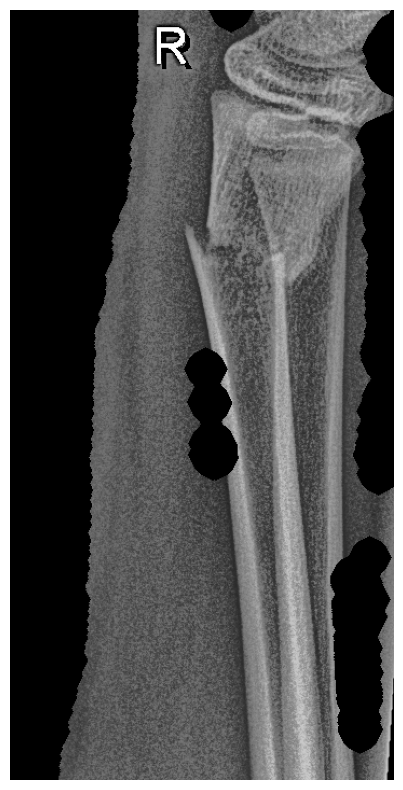

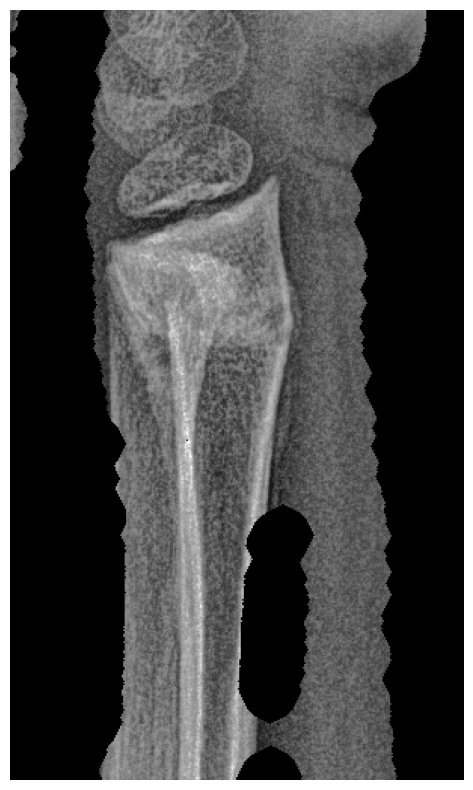

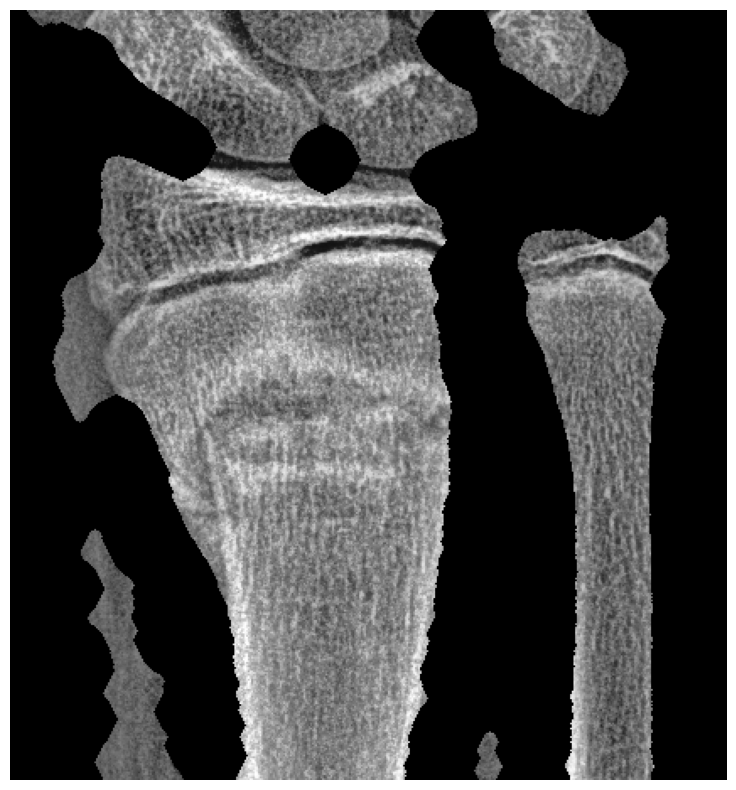

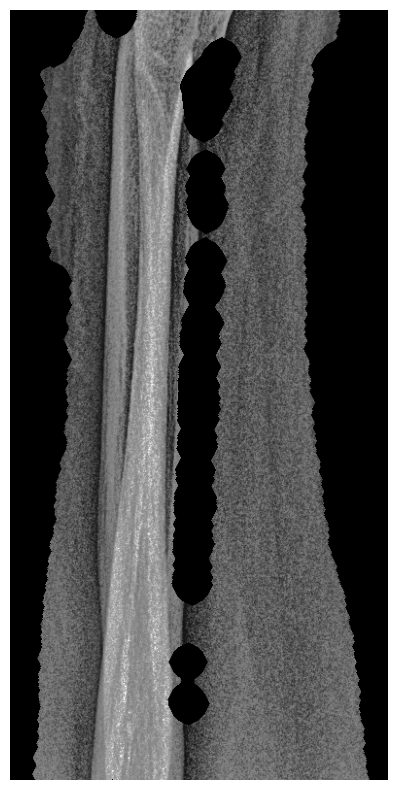

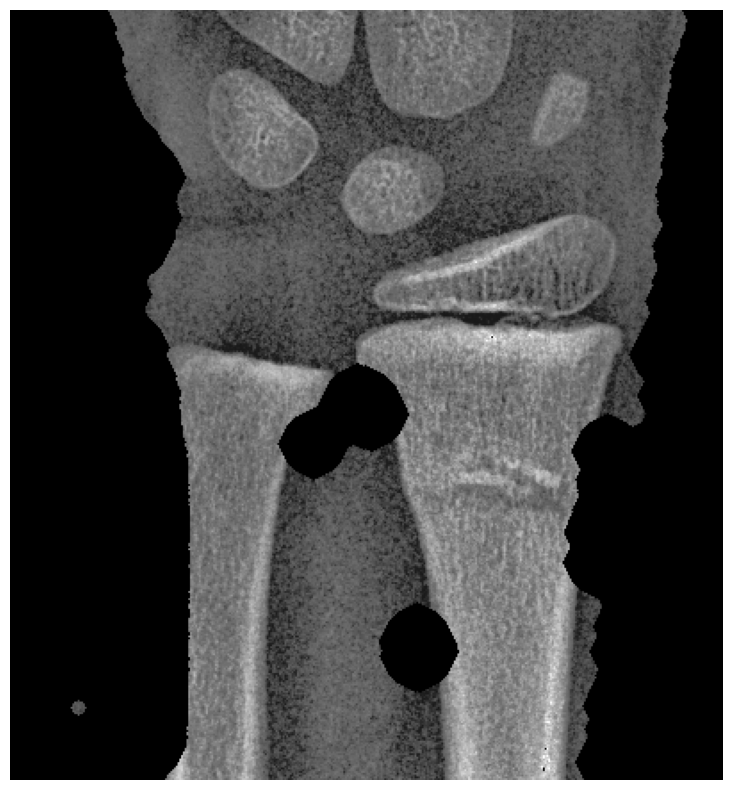

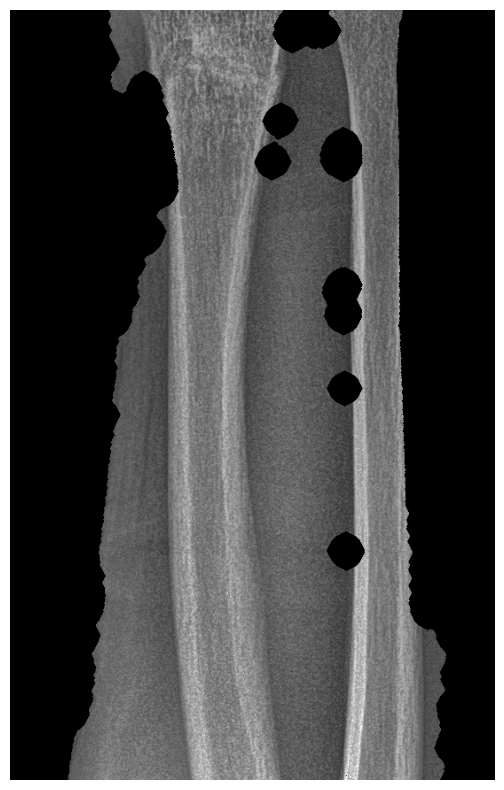

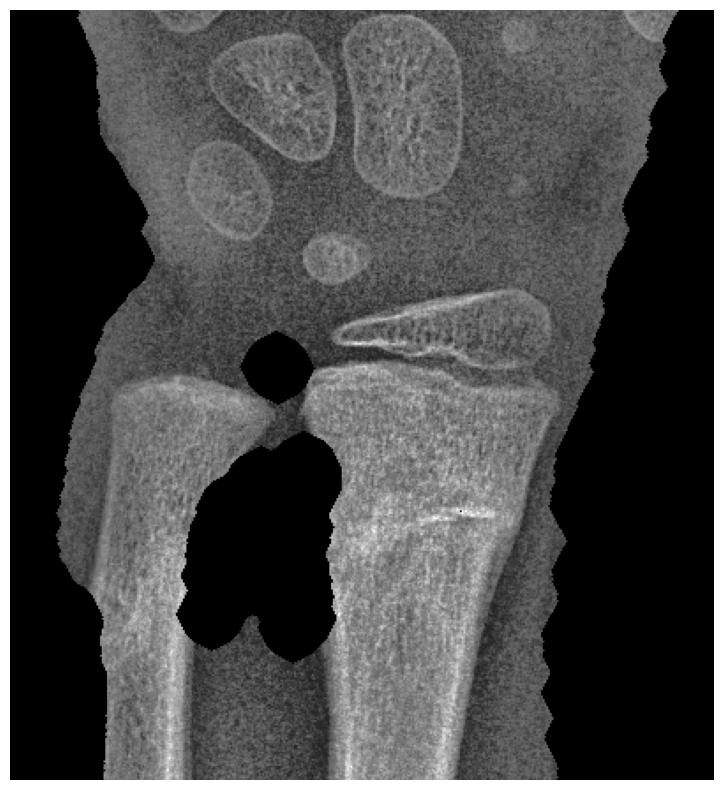

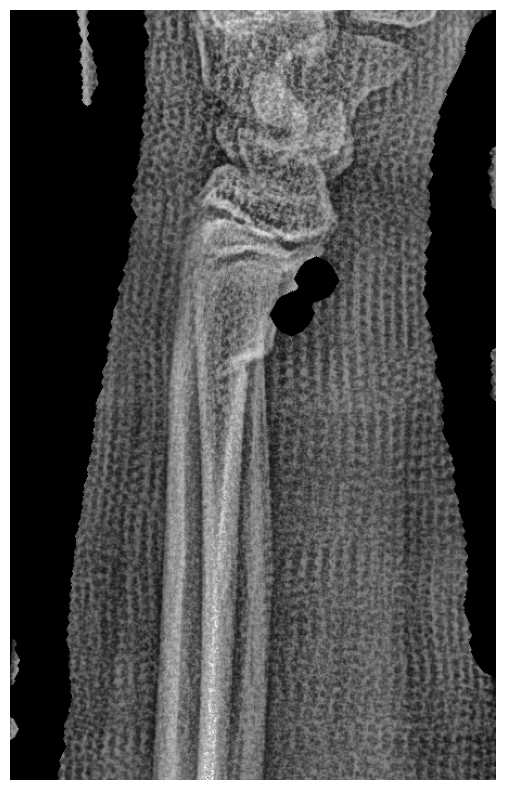

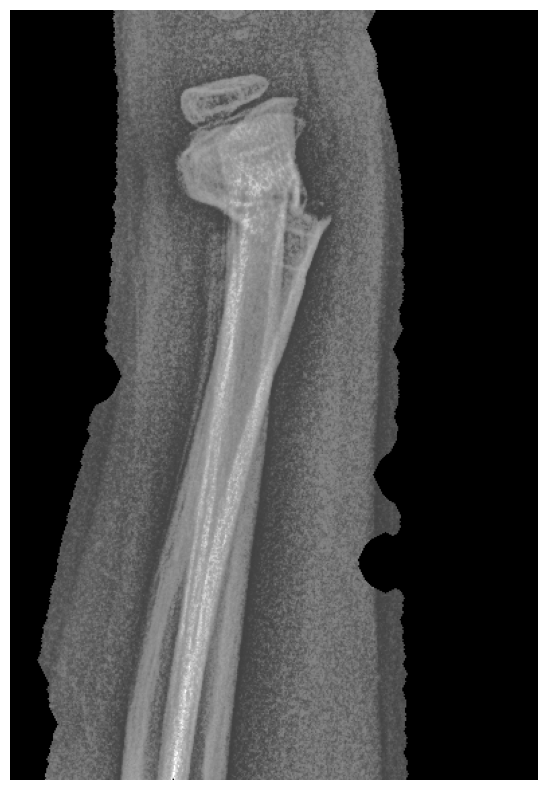

KeyboardInterrupt: 

In [16]:
intensity_crop = 0
outputbitdepth = 8 
unsharp = True
dilate_num = 1
erosion_num = 4

for j, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, img_train_folder, 'fracture/*.png'))):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image.ndim == 3:
        image = rgb2gray(image)

    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)

    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh

    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)

    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)

    # Apply multiple erosions
    eroded_mask = closed_mask
    for _ in range(erosion_num):
        eroded_mask = erosion(eroded_mask, selem)
        
    # Apply opening to the eroded mask
    opened_mask = opening(eroded_mask, selem)

    # Apply closing to the opened mask
    closed_mask = closing(opened_mask, selem)

    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))

    plt.figure(figsize=(10, 10))
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')
    plt.show()

    if j > 20:
        break

/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


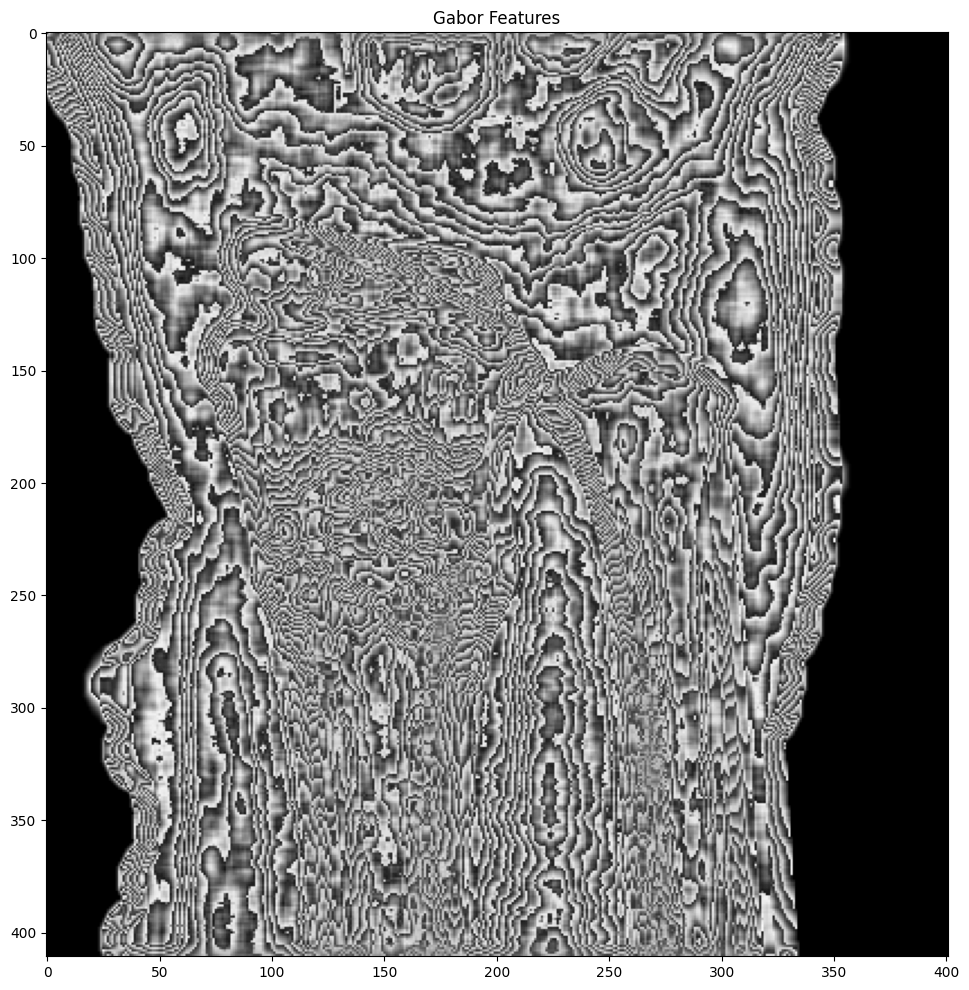

In [23]:
import numpy as np
import cv2
from scipy.ndimage import convolve
import torch
import torchvision.models as models

class GaborDescriptor:
    def __init__(self, use_alexnet=False, padding='nopad', normalize=True, lambdas=[1.0, 2.0, 3.0], thetas=np.arange(0, np.pi, np.pi / 6), sigmas=[3, 5]):
        self.use_alexnet = use_alexnet
        self.lambdas = lambdas
        self.thetas = thetas
        self.sigmas = sigmas
        self.normalize = normalize
        self.padding = padding
        self.kernels = self.build_kernels()
    
    def build_kernels(self):
        if self.use_alexnet:
            return self.build_alexnet_kernels()
        else:
            return self.build_gabor_kernels()
    
    def build_gabor_kernels(self):
        kernels = []
        for theta in self.thetas:
            for sigma in self.sigmas:
                for lambd in self.lambdas:
                    ksize = int(6 * sigma + 1)  # Kernel size, typically 6*sigma + 1
                    gamma = 1.0                # Spatial aspect ratio
                    psi = 0                    # Phase offset
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
                    kernels.append(kernel)
        if self.normalize:
            kernels = [kernel / np.linalg.norm(kernel) for kernel in kernels]
        return kernels

    def build_alexnet_kernels(self):
        # Load the pre-trained AlexNet model
        alexnet = models.alexnet(pretrained=True)
        
        # Extract the first convolutional layer's weights
        conv1_weights = alexnet.features[0].weight.data.numpy()
        conv1_weights_avg = np.mean(conv1_weights, axis=1, keepdims=True)
        if self.normalize:
            conv1_weights_avg -= conv1_weights_avg.min()
            conv1_weights_avg /= conv1_weights_avg.max()
        
        # Extract the first filter from the first channel
        # and prepare it as a single kernel
        kernels = [conv1_weights_avg[i, 0, :, :] for i in range(conv1_weights_avg.shape[0])]
        
        return kernels

    def apply_pooling(self, responses, pool_size=2):
        return np.mean(responses, axis=0)

    def __call__(self, image):
        responses = self.apply_filters(image)
        pooled_response = self.apply_pooling(responses)
        return pooled_response

    def apply_filters(self, image):
        responses = []
        for kernel in self.kernels:
            if self.padding == 'nopad':
                filtered = convolve(image, kernel, mode='constant', cval=0.0)
            else:
                filtered = convolve(image, kernel, mode='reflect')
            responses.append(filtered)
        return np.array(responses)

# image = preprocess(image)

# Initialize GaborDescriptor
# Set `use_alexnet=True` to use the first filter from AlexNet
gabor_descriptor = GaborDescriptor(use_alexnet=True, padding='nopad', normalize=True)

# Apply filters to the image
gabor_features = gabor_descriptor(image)

plt.figure(figsize=(12, 12))
plt.imshow(gabor_features, cmap='gray')
plt.title('Gabor Features')
plt.show()

In [83]:
def extract_gabor_features(image, ksize=7):
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filters.append(kern)
    
    features = []
    for kern in filters:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kern)
        features.append(filtered)
    
    return features

In [86]:
features = extract_gabor_features(image)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import gabor

In [ ]:
mode = 'train'
class_name = 'fracture'

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    break


In [8]:
def apply_gabor_filter(image, ksize, sigma, theta, lambd, gamma, psi):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    filtered_img = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_img
mode = 'train'
class_name = 'fracture'

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = preprocess(image)

    # Apply the Gabor filter
    ksize = 31  # size of the filter
    sigma = 4.0  # standard deviation of the Gaussian function
    theta = np.pi/2  # orientation of the normal to the parallel stripes of the Gabor function
    lambd = 10.0  # wavelength of the sinusoidal factor
    gamma = 0.5  # spatial aspect ratio
    psi = 0  # phase offset

    filtered_image = 0
    for theta in np.arange(0, np.pi, np.pi / 36):
        filtered_image += apply_gabor_filter(image, ksize, sigma, theta, lambd, gamma, psi)

    # Use the Canny edge detector
    edges = cv2.Canny(filtered_image, 50, 150)

    # Display the results
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Gabor Filtered Image')
    plt.imshow(filtered_image, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Canny Edges')
    plt.imshow(edges, cmap='gray')

    plt.show()

KeyboardInterrupt: 

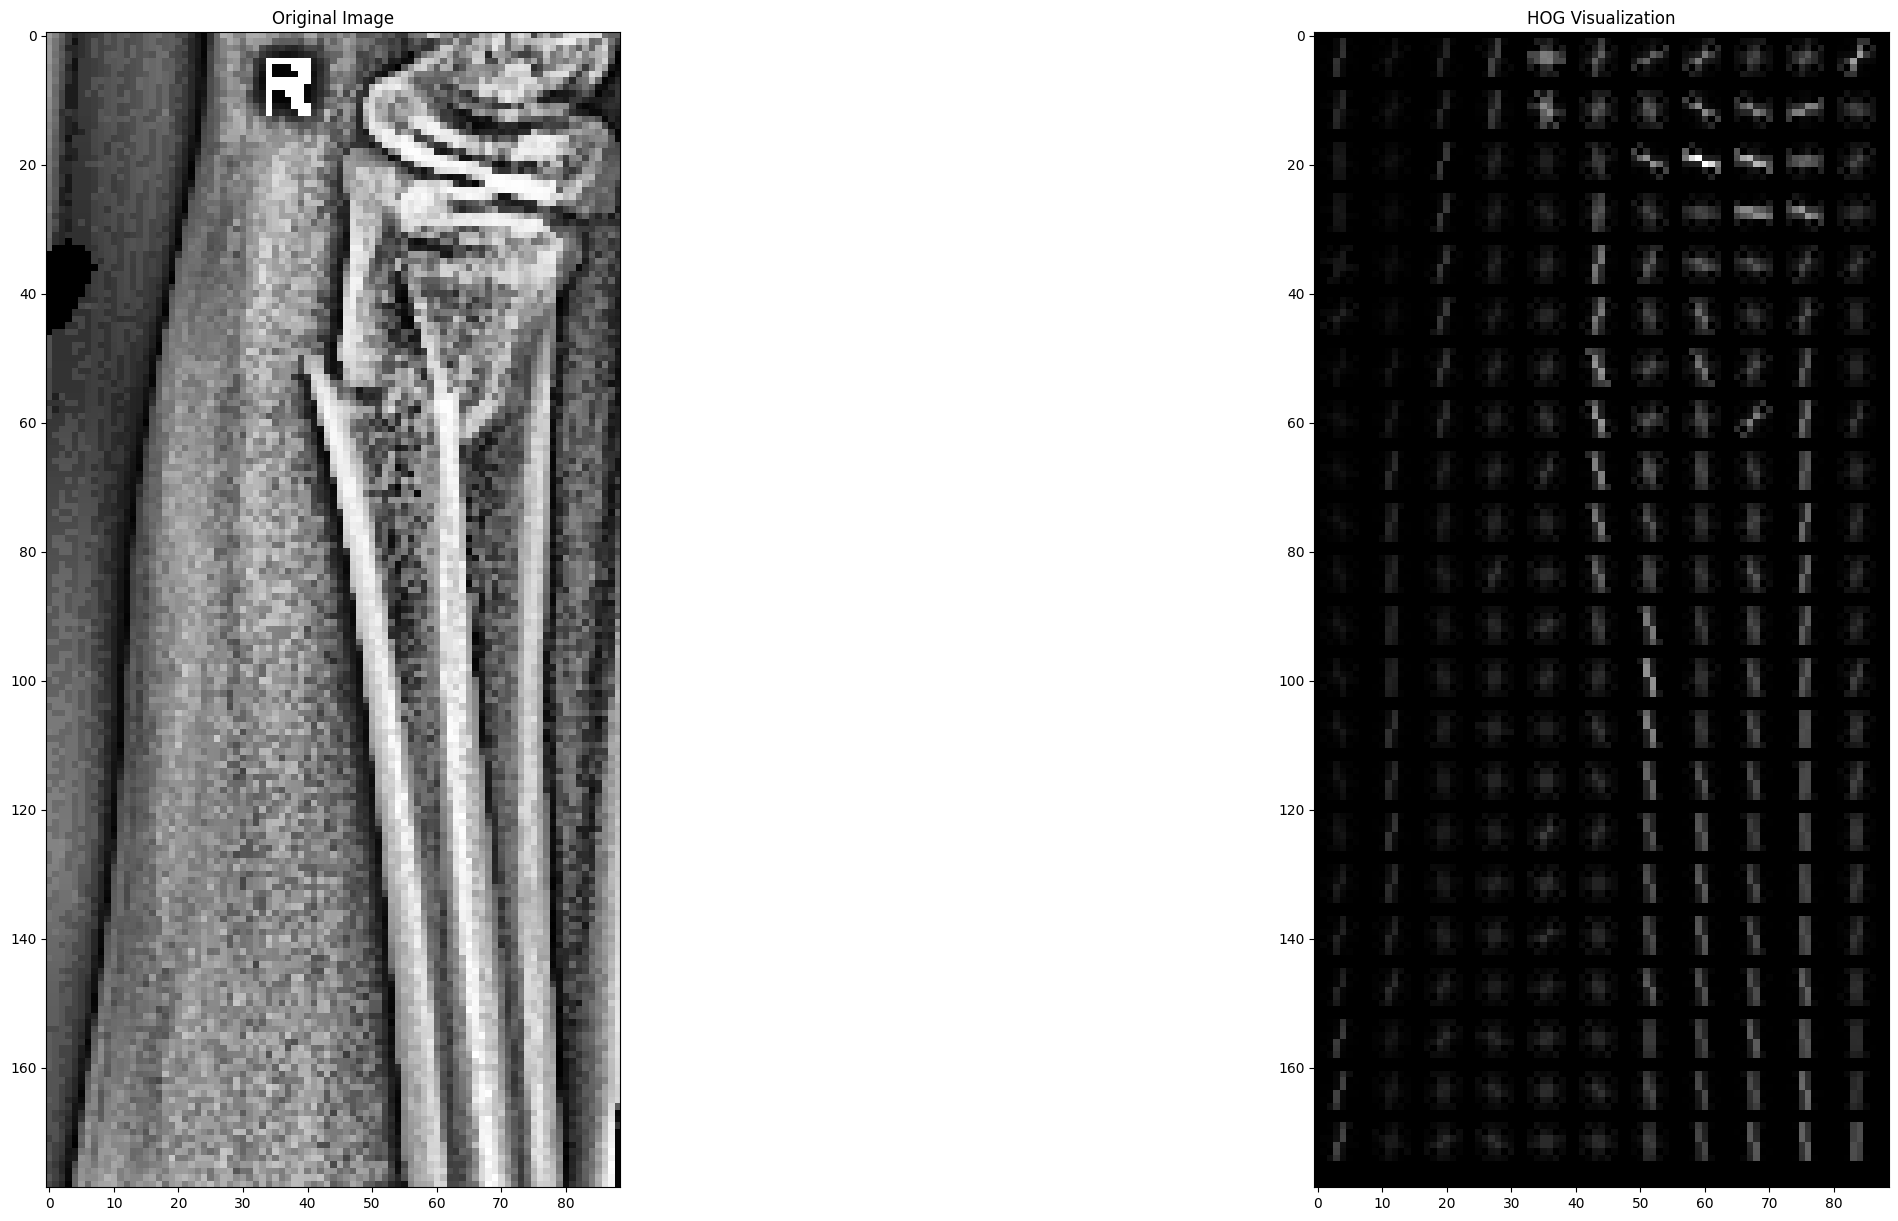

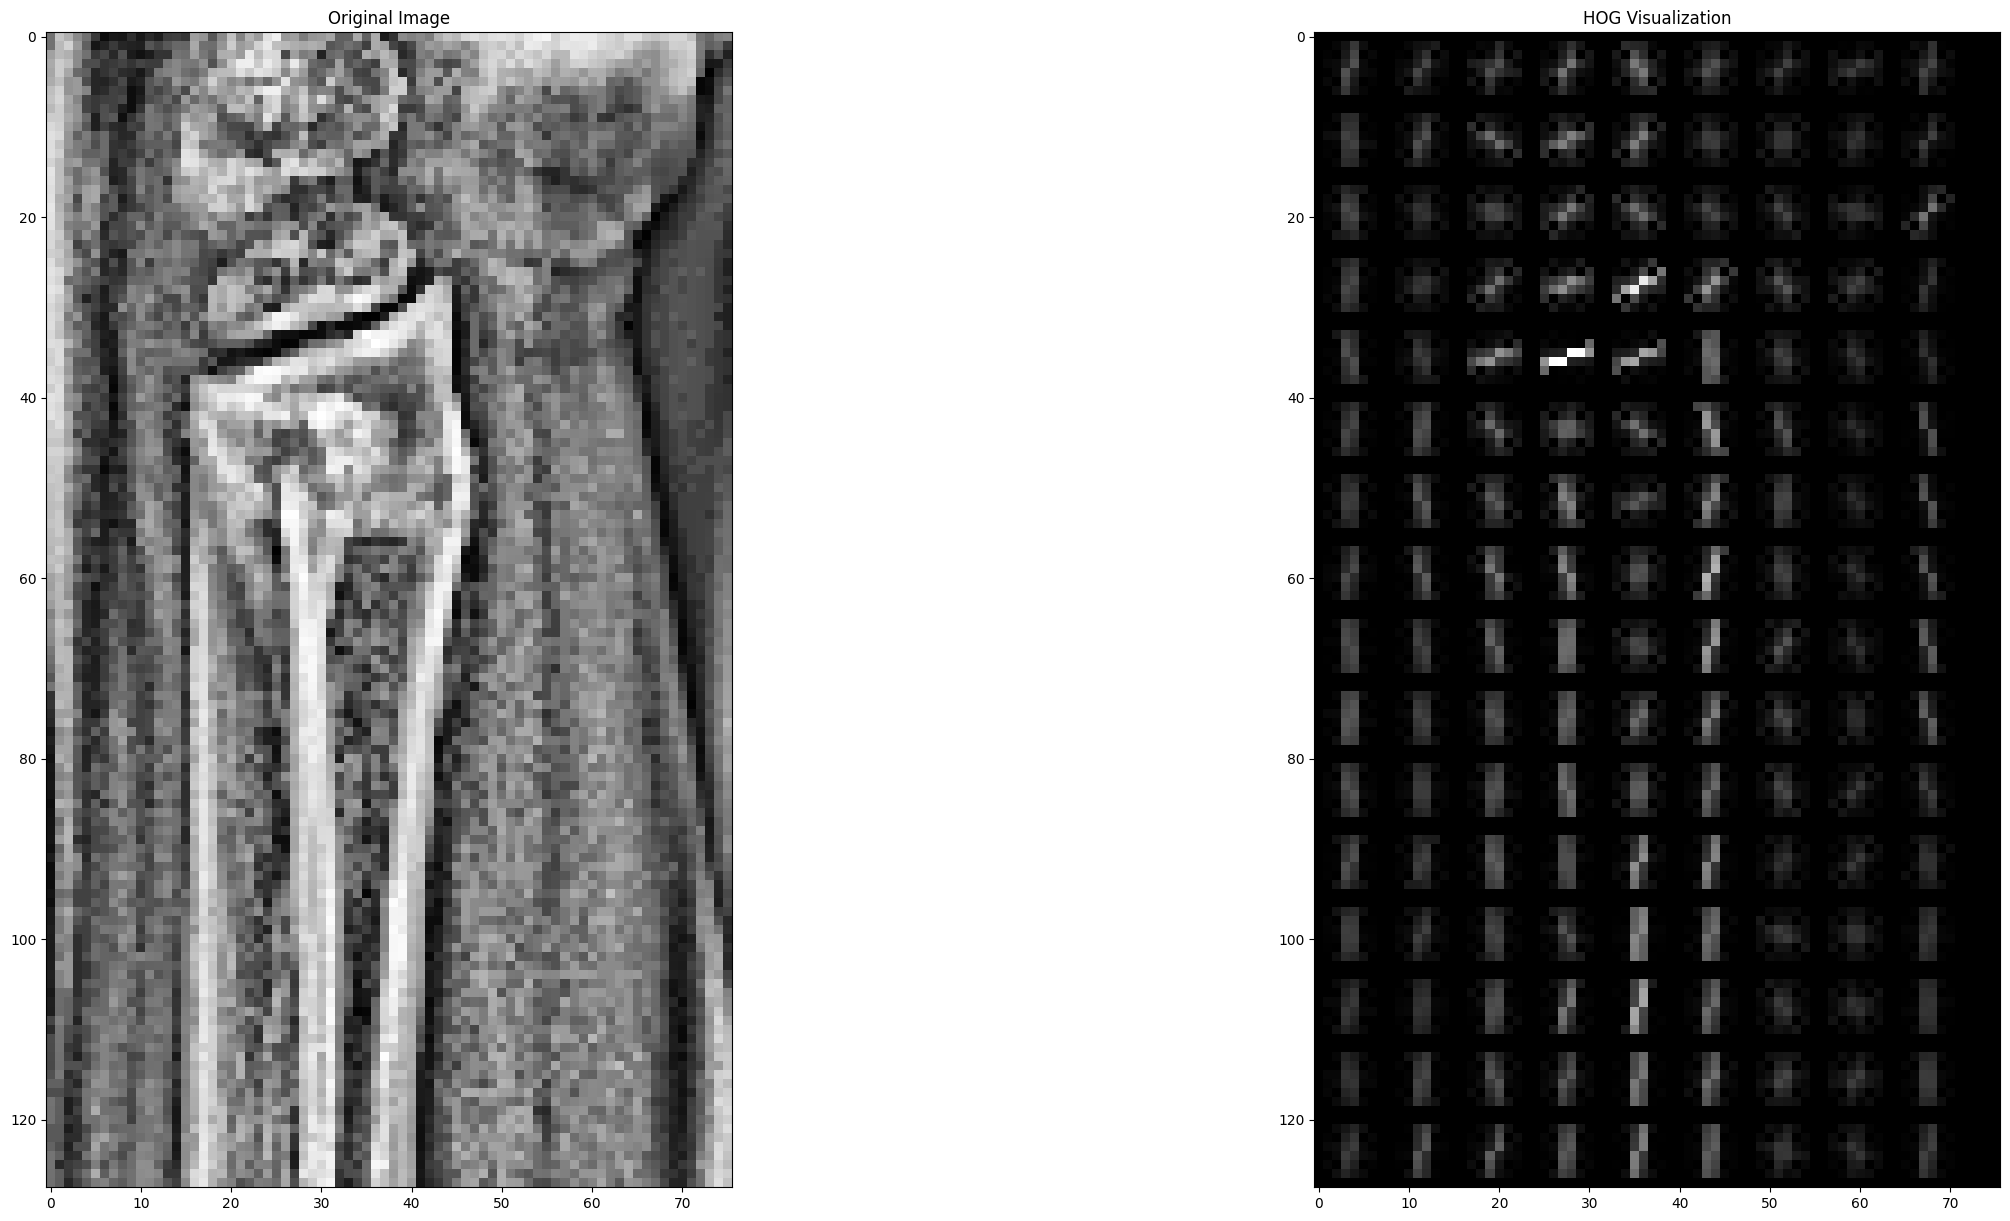

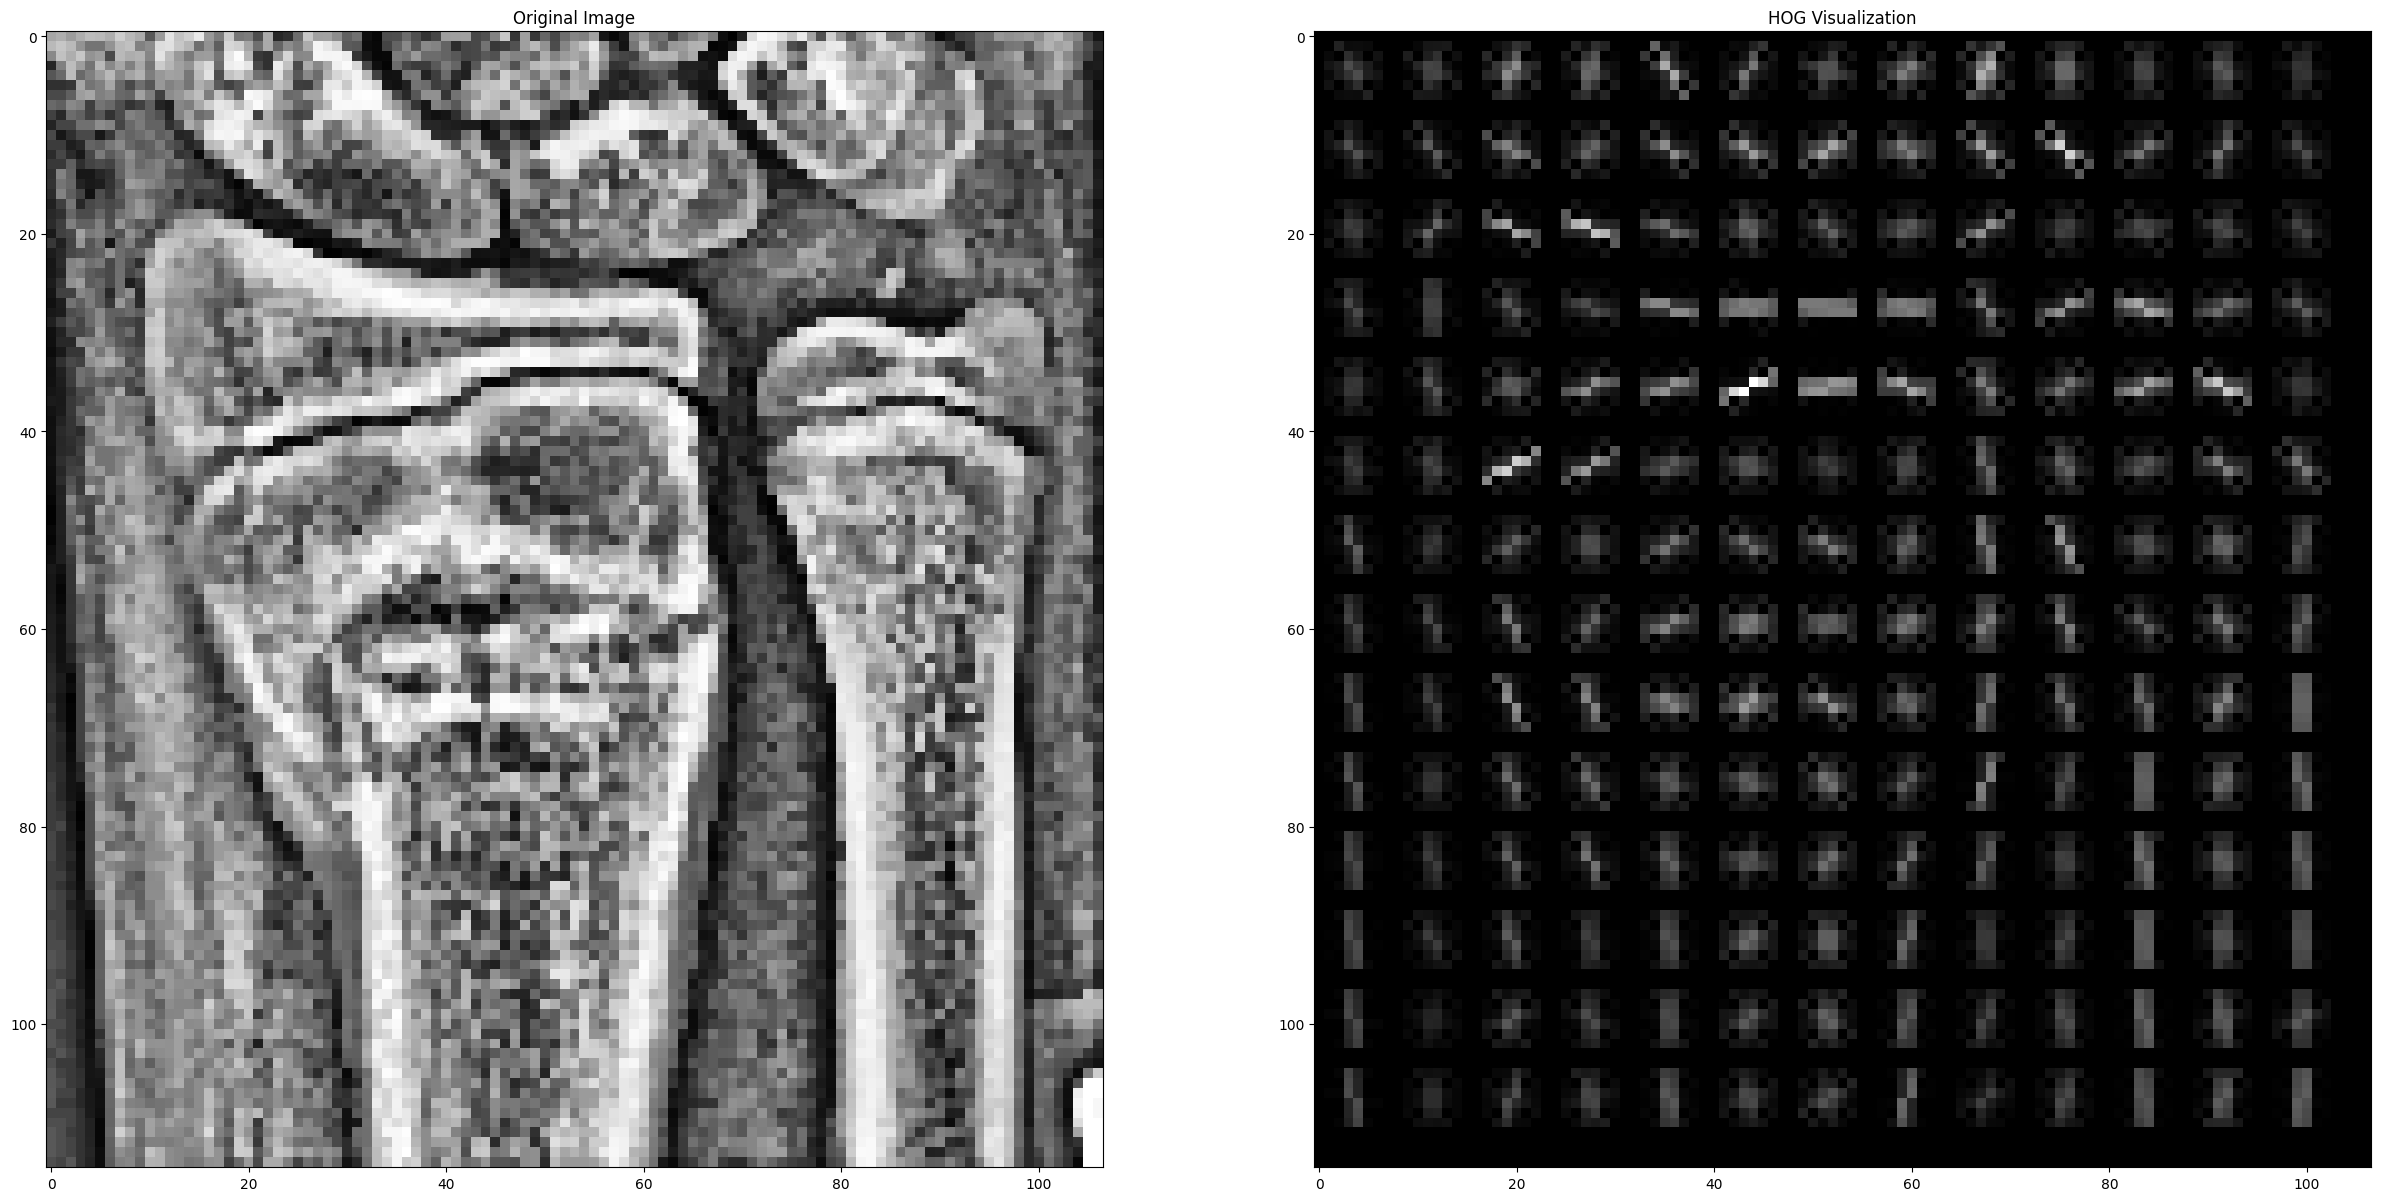

KeyboardInterrupt: 

<Figure size 3000x1500 with 0 Axes>

In [12]:
from skimage.feature import hog

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = skimage.measure.block_reduce(image, (4,4), np.max)
    
    image = preprocess(image)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display the results
    plt.figure(figsize=(30, 15))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('HOG Visualization')
    plt.imshow(hog_image, cmap='gray')

    plt.show()

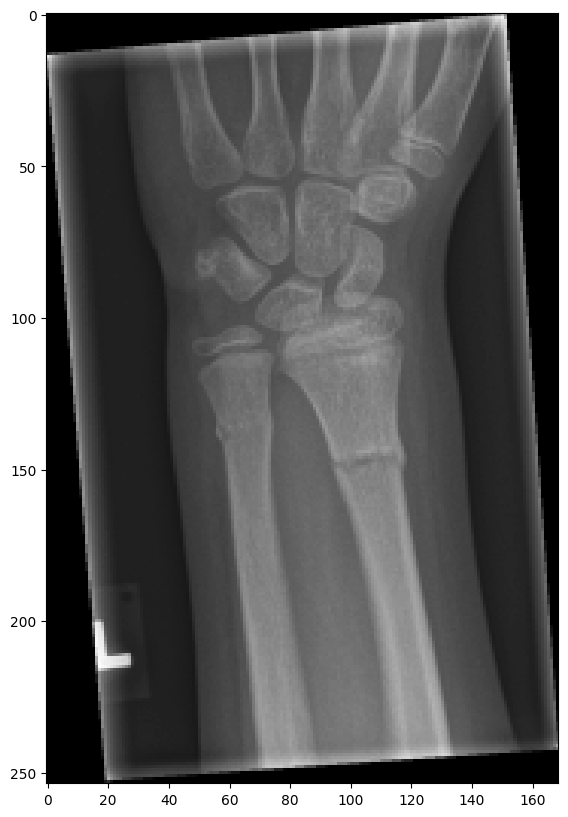

In [15]:
image = cv2.imread('MLDataset/images/train/fracture/0160_0598179425_01_WRI-L1_F009.png', cv2.IMREAD_GRAYSCALE)
image = skimage.measure.block_reduce(image, (4,4), np.mean)

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.show()


In [13]:
image.shape

(338, 226)